# MODEL PERFORMANCE EVALUATION

In [1]:
import logging
logging.basicConfig(level=logging.WARNING)
import math
import os
import time
import random

import numpy as np
import torch
from PIL import Image
from torchvision.transforms import v2 as transforms
from tqdm import tqdm

from matplotlib import pyplot as plt

### Utilities

In [2]:
def batch_and_forward(model, stack, device, normalize = True):
    batched = torch.stack(stack, 0)
    if normalize:
        embeddings = torch.nn.functional.normalize(model.to(device)(batched.to(device)), p=2, dim=1)
    else:
        embeddings = model.to(device)(batched.to(device))
    return embeddings

def get_embeddings(model, transform, dataset, device, batch_size=32, normalize = True, verbose = True, save_to_file = True):
    # Find cached embeddings at <dataset>.npz
    if os.path.exists(dataset + '.npz'):
        cached = np.load(dataset + '.npz')
        embeddings = cached['embeddings']
        labels = cached['labels']
        return embeddings, labels, 0 # dummy fps
    labels = []
    img_fullpaths = []
    for label in tqdm(os.listdir(dataset)):
        img_path = os.listdir(os.path.join(dataset, label))
        img_fullpaths += [os.path.join(dataset, label, img) for img in img_path]
        labels += [label] * len(img_path)
    total_images = len(img_fullpaths)
    if verbose:
        print(f"Folder {dataset} contains {total_images} images and {len(os.listdir(dataset))} labels")
    embeddings = []
    stack = []

    start = time.time()
    for img_idx in tqdm(range(0, len(img_fullpaths))):
        img = transform(Image.open(img_fullpaths[img_idx]))
        stack.append(img)
        if len(stack) == batch_size:
            embeddings.extend(batch_and_forward(model, stack, device, normalize = normalize).detach().cpu())
            stack = []
    if len(stack) > 0:
        embeddings.extend(batch_and_forward(model, stack, device, normalize = normalize).detach().cpu())
        stack = []

    end = time.time()
    exec_time = end - start
    fps = total_images / exec_time
    assert (len(embeddings) == len(labels)) and (len(embeddings) == total_images), f"Number of embeddings and labels must be equal to the number of images. Got {len(embeddings)} embeddings and {len(labels)} labels with {total_images} images."
    if verbose:
        print(f"Total execution time: {exec_time:.2f} seconds")
        print(f"Average FPS: {fps:.2f}")
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    if save_to_file:
        np.savez(dataset, embeddings = embeddings, labels = labels)
    return embeddings, labels, fps

def write_to_file(embeddings, labels, embedding_file, label_file):
    if len(labels) == 1:
        labels *= len(embeddings)
    with open(embedding_file, 'a') as f:
        f.writelines([' '.join([str(x) for x in e.detach().cpu().numpy()]) + '\n' for e in embeddings])
    with open(label_file, 'a') as f:
        for l in labels:
            f.write(l + '\n')

def calc_val_far(confusion_matrix):
    far, val = np.nan_to_num(confusion_matrix[:, 1] / np.sum(confusion_matrix, 1), 0)
    return val, far

def threshold_from_far(far, embeddings, labels, thresholds=np.arange(0, 4, 0.01)):
    logger = logging.getLogger("ThresholdFromFAR")
    def val_far(pred, actual):
        '''Return val, far from an array of pred and actual'''
        count_ta = np.sum(pred + actual == 2) # true positive
        count_fa = np.sum(pred - actual == 1) # pred must be 1 and actual must be 0
        count_total = np.sum(actual == 1)
        val = count_ta / count_total
        far = count_fa / (len(pred) - count_total)
        return val, far
    def pred_actual(threshold, embeddings=embeddings, labels=labels):
        pred = []
        actual = []
        embeddings = torch.from_numpy(embeddings)
        dist = torch.cdist(embeddings, embeddings)
        actual = np.concatenate([(labels[idx1] == labels[idx1 + 1:]).astype(np.uint8) for idx1 in range(len(labels))])
        pred = torch.cat([(dist[idx1, idx1 + 1:] <= threshold).type(torch.uint8) for idx1 in range(len(labels))])
        return np.array(pred), np.array(actual)
    pred_far = 0
    for idx in range(len(thresholds)):
        pred, actual = pred_actual(thresholds[idx])
        val, far_ = val_far(pred, actual)
        logger.info(f"Current threshold: {thresholds[idx]:.3f}, val: {val:.3f}, far: {far_:.3f}")
        if far_ > far:
            approx = thresholds[idx] - (far_ - far) / (far_ - pred_far) * (thresholds[idx] - thresholds[idx - 1])
            return approx
        pred_far = far_

def confusion_matrix(embeddings, labels, threshold):
    confusion_matrix = np.zeros((2, 2))
    for idx in range(len(embeddings) - 1):
        diff = np.subtract(embeddings[idx], embeddings[idx + 1:])
        dist = np.sum(np.square(diff),1)
        pred = (dist <= threshold).type(torch.uint8).numpy()
        actual = (labels[idx] == labels[idx + 1:]).astype(np.uint8)
        confusion_matrix[1, 1] = np.sum(pred + actual == 2) # true positive
        confusion_matrix[0, 1] = np.sum(pred - actual == 1) # pred must be 1 and actual must be 0
        confusion_matrix[1, 0] = np.sum(actual - pred == 1) # pred must be 0 and actual must be 1
        confusion_matrix[0, 0] = np.sum(pred + actual == 0) # true negative
    return confusion_matrix

def val_far(embeddings, labels, threshold):
    total_images = len(embeddings)
    count_ta = 0
    count_fa = 0
    count_total = 0
    count_actual_positive = 0
    for idx in tqdm(range(total_images)):
            dist = np.linalg.norm(embeddings[idx] - embeddings[idx + 1:], axis=-1)
            pred = (dist <= threshold).astype(np.uint8)
            actual = (labels[idx] == labels[idx + 1:]).astype(np.uint8)
            count_ta += np.sum(pred + actual == 2) # true positive
            count_fa += np.sum(pred - actual == 1) # pred must be 1 and actual must be 0
            count_actual_positive += np.sum(actual == 1)
            count_total += len(actual)
    val = count_ta / count_actual_positive
    far = count_fa / (count_total - count_actual_positive)
    return val, far

def threshold_best_accuracy(embeddings, labels, *, thresholds = None):
    logger = logging.getLogger("ThresholdBestAccuracy")
    logger.info("Calculating best threshold for the highest accuracy...")
    if thresholds is None:
        thresholds = np.arange(0, 4, 10e-2)
    def pred_actual(threshold, embeddings=embeddings, labels=labels):
        pred = []
        actual = []
        embeddings = torch.from_numpy(embeddings)
        dist = torch.cdist(embeddings, embeddings)
        actual = np.concatenate([(labels[idx1] == labels[idx1 + 1:]).astype(np.uint8) for idx1 in range(len(labels))])
        pred = torch.cat([(dist[idx1, idx1 + 1:] <= threshold).type(torch.uint8) for idx1 in range(len(labels))])
        return np.array(pred), np.array(actual)
    
    accuracy = []
    for idx in range(len(thresholds)):
        pred, actual = pred_actual(thresholds[idx])
        accuracy.append(np.sum(pred == actual) / len(pred))
        logger.info(f"Current threshold: {thresholds[idx]:.3f}, accuracy: {accuracy[idx]:.3f}")
    return thresholds[np.argmax(accuracy)]

def calc_acc_tpr_fpr(confusion_matrix):
    acc = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    tpr = confusion_matrix[0, 0] / np.sum(confusion_matrix[0, :])
    fpr = confusion_matrix[0, 1] / np.sum(confusion_matrix[0, :])
    return acc, tpr, fpr

def full_evaluate(embeddings, labels, fars: list, *, thresholds = None, train_times = 10):
    logger = logging.getLogger("FullEvaluate")
    logger.info("Encode label to int...")
    label2int = {label: idx for idx, label in enumerate(set(labels))}
    labels = np.array([label2int[label] for label in labels])
    result = {}
    logger.info("Calculating Validation rate given FAR...")
    for far in fars:
        threshold = 0
        for trial in range(train_times):
            train_idx, _ = torch.utils.data.random_split(torch.arange(len(embeddings)), [0.5, 0.5])
            train_embeddings = embeddings[train_idx]
            train_labels = np.array(labels)[train_idx]      
            threshold += threshold_from_far(far, train_embeddings, train_labels, thresholds)
        threshold /= train_times # average threshold
        val, far_ = val_far(embeddings, labels, threshold)
        info = f"Threshold: {threshold:.3f}: val: {val:.3f}, far: {far_:.3f}"
        logger.info(info)
        print(info)
        result[f'validation_rate@far={far}'] = val
    return result

def false_positive_negative(embeddings, labels, threshold):
    label2int = {label: idx for idx, label in enumerate(set(labels))}
    labels = np.array([label2int[label] for label in labels])
    total_images = len(embeddings)
    is_false_positive = []
    is_false_negative = []
    for idx in tqdm(range(total_images)):
            dist = np.linalg.norm(embeddings[idx] - embeddings[idx + 1:], axis=-1)
            pred = (dist <= threshold).astype(np.uint8)
            actual = (labels[idx] == labels[idx + 1:]).astype(np.uint8)
            fp = (pred - actual == 1).astype(np.uint8)
            fn = (actual - pred == 1).astype(np.uint8)
            is_false_positive.extend([(idx, idx + 1 + idx2) for idx2 in np.where(fp == 1)[0]])
            is_false_negative.extend([(idx, idx + 1 + idx2) for idx2 in np.where(fn == 1)[0]])
    return is_false_positive, is_false_negative


# -------------------------

# Copied from facenet-pytorch evaluation
from sklearn.model_selection import KFold

# LFW functions taken from David Sandberg's FaceNet implementation
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric

    return dist

def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds))
    fprs = np.zeros((nrof_folds))
    accuracy = np.zeros((nrof_folds))
    best_threshold_index = []

    is_false_positive = []
    is_false_negative = []

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx], _ ,_ = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index.append(np.argmax(acc_train))
        tprs[fold_idx], fprs[fold_idx], accuracy[fold_idx], is_fp, is_fn = calculate_accuracy(thresholds[best_threshold_index[-1]], dist[test_set], actual_issame[test_set])

        is_false_positive.extend(is_fp)
        is_false_negative.extend(is_fn)
    return tprs, fprs, accuracy, is_false_positive, is_false_negative, [thresholds[idx] for idx in best_threshold_index]

def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    is_fp = np.logical_and(predict_issame, np.logical_not(actual_issame))
    is_fn = np.logical_and(np.logical_not(predict_issame), actual_issame)

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc, is_fp, is_fn

def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the threshold that gives FAR = far_target
        pred_far = 0
        approx = 0
        for threshold_idx, threshold in enumerate(thresholds):
            _, curr_far = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
            if curr_far > far_target:
                approx = thresholds[threshold_idx] - (curr_far - far_target) / (curr_far - pred_far) * (thresholds[threshold_idx] - thresholds[threshold_idx - 1])
                break
        threshold = approx

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean, threshold

def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far

def lfw_evaluate(embeddings, actual_issame, nrof_folds=10, distance_metric=0, subtract_mean=False, far_target=1e-3, thresholds = np.arange(0, 4, 10e-3)):
    # Calculate evaluation metrics
    thresholds = thresholds
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy, fp, fn, roc_threshold = calculate_roc(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    thresholds = thresholds
    val, val_std, far, far_threshold = calculate_val(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), far_target, nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    return tpr, fpr, accuracy, val, val_std, far, fp, fn, roc_threshold, far_threshold

def add_extension(path):
    if os.path.exists(path+'.jpg'):
        return path+'.jpg'
    elif os.path.exists(path+'.png'):
        return path+'.png'
    else:
        raise RuntimeError('No file "%s" with extension png or jpg.' % path)

def get_paths(lfw_dir, pairs):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:
        if len(pair) == 3:
            path0 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])))
            path1 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[2])))
            issame = True
        elif len(pair) == 4:
            path0 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])))
            path1 = add_extension(os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % int(pair[3])))
            issame = False
        if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)

    return path_list, issame_list

def read_pairs(pairs_filename):
    pairs = []
    with open(pairs_filename, 'r') as f:
        for line in f.readlines()[1:]:
            pair = line.strip().split()
            pairs.append(pair)
    return np.array(pairs, dtype=object)

### Constants

In [3]:
PAIR_PATH = r'data/pairs.txt' # Path to the LFW pairs file
LFW_DIR = r"data/lfw-cropped" # Path to the cropped LFW folder
DATA_DIR = [] # Path to the other datasets used for evaluation
BATCH_SIZE = 32 # Batch size for model inference
FAR = [1e-1, 1e-2, 1e-3, 1e-4] # Evaluate at these False Accept Rates
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 1. Load the model

In [24]:
# Load your model and needed transformations here as variables `model` and `transform`
# Also give it a name by specify `model_name`

# Model
model = None

# Name
model_name = ""

# Transform
transform = transforms.Identity()

/home/trickywhitecat/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


### 2. LFW Evaluation

##### 2.1. Data preparation

In [25]:
labels = []
img_fullpaths = []
for label in tqdm(os.listdir(LFW_DIR)):
    img_path = os.listdir(os.path.join(LFW_DIR, label))
    img_fullpaths += [os.path.join(LFW_DIR, label, img) for img in img_path]
    labels += [label] * len(img_path)
total_images = len(img_fullpaths)
print(f"Folder {LFW_DIR} contains {total_images} images and {len(os.listdir(LFW_DIR))} labels")

100%|██████████| 5749/5749 [00:00<00:00, 56167.65it/s]

Folder data/lfw-cropped contains 13233 images and 5749 labels


##### 2.2. Get Embeddings

In [26]:
embeddings, _, fps = get_embeddings(model, transform, LFW_DIR, device, batch_size=BATCH_SIZE, normalize = True, verbose = True, save_to_file=False)
embeddings_dict = dict(zip(img_fullpaths, embeddings))

100%|██████████| 5749/5749 [00:00<00:00, 59326.29it/s]


Folder data/lfw-cropped contains 13233 images and 5749 labels


100%|██████████| 13233/13233 [01:19<00:00, 166.23it/s]


Total execution time: 79.68 seconds
Average FPS: 166.08


##### 2.3. Evaluate

In [27]:
result = {"model": model_name,
          'embedding_size': embeddings.shape[-1],
          'device': device,
          'fps': fps,}

In [28]:
lfw_result = {}
pairs = read_pairs(PAIR_PATH)
path_list, issame_list = get_paths(LFW_DIR, pairs)
embeddings = np.array([embeddings_dict[path] for path in path_list])
for far in FAR:
    if far == FAR[0]:
        tpr, fpr, accuracy, val, val_std, truefar, fp, fn, roc_threshold, far_threshold = lfw_evaluate(embeddings, issame_list, far_target=far, distance_metric=0)
        lfw_result['accuracy'] = np.mean(accuracy)
        lfw_result['true_positive_rate'] = np.mean(tpr)
        lfw_result['false_positive_rate'] = np.mean(fpr)
        print(f'Accuracy: {np.mean(accuracy):.3%}+-{np.std(accuracy):.3%} with threshold={np.mean(roc_threshold):.5f}')
    else:
        thresholds = np.arange(far_threshold * (0.8), far_threshold, 10e-6 * far_threshold, dtype=np.float64)
        _, _, _, val, val_std, truefar, _, _, roc_threshold, far_threshold = lfw_evaluate(embeddings, issame_list, far_target=far, distance_metric=0, thresholds = thresholds)
    lfw_result[f'validation_rate@far={far}'] = val
    print(f'Validation rate: {val:.3%}+-{val_std:.3%} @ FAR={truefar:.3%} with threshold={far_threshold:.5f}')
result['lfw_result'] = lfw_result

Accuracy: 88.367%+-1.312% with threshold=1.72000
Validation rate: 85.500%+-1.128% @ FAR=10.433% with threshold=1.76989
Validation rate: 71.633%+-2.198% @ FAR=1.033% with threshold=1.59325
Validation rate: 59.333%+-3.152% @ FAR=0.133% with threshold=1.45537
Validation rate: 38.667%+-13.128% @ FAR=0.000% with threshold=1.28521


##### Interactive Demo

In [29]:
thresholds = 2
tpr, fpr, accuracy, val, val_std, truefar, fp, fn, roc_threshold, far_threshold = lfw_evaluate(embeddings, issame_list, far_target=far, distance_metric=0, thresholds = [thresholds])
print(f"True Positive Rate: {np.mean(tpr):.3%}")
print(f"False Positive Rate: {np.mean(fpr):.3%}")
print(f"Accuracy: {np.mean(accuracy):.3%}")
print(f"Validation Rate: {val:.3%}")
print(f"Valudation Rate's Standard Devitation: {val_std:.3%}")
print(f"False Acceptance Rate: {truefar:.3%}")

True Positive Rate: 97.600%
False Positive Rate: 67.233%
Accuracy: 65.183%
Validation Rate: 97.600%
Valudation Rate's Standard Devitation: 0.867%
False Acceptance Rate: 67.233%


##### Visualize False Positives

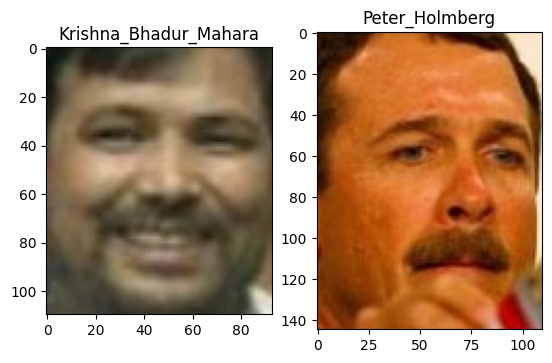

In [30]:
fp_index = np.random.choice(np.where(fp)[0])
pair = path_list[fp_index * 2: fp_index * 2 + 2]
im1 = Image.open(pair[0])
im2 = Image.open(pair[1])
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im1)
ax[1].imshow(im2)
name1 = pair[0].split('/')[-2]
name2 = pair[1].split('/')[-2]
ax[0].title.set_text(name1)
ax[1].title.set_text(name2)

### 3. Evaluate on Custom Dataset

##### 3.1. Data preparation

In [31]:
datasets_name = [os.path.basename(path) for path in DATA_DIR]
custom_results = {}
print(f"{len(datasets_name)} datasets specified: {datasets_name}")

0 datasets specified: []


##### 3.2. Perform evaluation on each dataset

In [32]:
for idx, dataset in enumerate(DATA_DIR):
    embeddings, labels, fps = get_embeddings(model, transform, dataset, device, batch_size=BATCH_SIZE, normalize = True, verbose = True)
    custom_results[datasets_name[idx]] = full_evaluate(embeddings, labels, FAR, thresholds = np.arange(1, 2, 10e-3))
result['custom_results'] = custom_results

In [33]:
custom_results

{}

In [34]:
threshold = 1.274
if len(DATA_DIR):
    fig, ax = plt.subplots(len(DATA_DIR), 4)
    ax = ax.reshape(len(DATA_DIR), 4)
    for idx, dataset in enumerate(DATA_DIR):
        img_fullpaths = []
        for label in tqdm(os.listdir(dataset)):
            img_path = os.listdir(os.path.join(dataset, label))
            img_fullpaths += [os.path.join(dataset, label, img) for img in img_path]
        total_images = len(img_fullpaths)
        embeddings, labels, _ = get_embeddings(model, transform, dataset, device, batch_size=BATCH_SIZE, normalize = True, verbose = True)
        fp, fn = false_positive_negative(embeddings, labels, threshold)
        fp_pair = random.choice(fp)
        fn_pair = random.choice(fn)
        img1 = Image.open(img_fullpaths[fp_pair[0]])
        img2 = Image.open(img_fullpaths[fp_pair[1]])
        img3 = Image.open(img_fullpaths[fn_pair[0]])
        img4 = Image.open(img_fullpaths[fn_pair[1]])
        [ax[idx, i].imshow(img) for i, img in enumerate([img1, img2, img3, img4])]
        [ax[idx, i].title.set_text(os.path.basename(img_fullpaths[fp_pair[i]])) for i in range(2)]
        [ax[idx, i + 2].title.set_text(os.path.basename(img_fullpaths[fn_pair[i]])) for i in range(2)]
        # Remove axis
        [ax[idx, i].axis('off') for i in range(4)]

### 4. Write to `result.json` file

In [35]:
import json
with open(r"result.json", 'a') as res_file:
    json.dump(result, res_file)